In [ ]:
import Plots

In [1]:
2+2

4

# OptimNewton.jl

In [ ]:
using OptimNewton

In [ ]:
f(x) = cos(x)
g(x) = -sin(x)
h(x) = -cos(x)

In [ ]:
x = 2.0
x = OptimNewton.optimize_newton(x, f, g, h; 
                    prints=true)

In [ ]:
pi

# Optim.jl

In [23]:
using Optim

In [25]:
function f(x)
    return (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
end

function g!(G, x)
    G[1] = -2.0 * (1.0 - x[1]) - 400.0 * (x[2] - x[1]^2) * x[1]
    G[2] = 200.0 * (x[2] - x[1]^2)
end

function h!(H, x)
    H[1, 1] = 2.0 - 400.0 * x[2] + 1200.0 * x[1]^2
    H[1, 2] = -400.0 * x[1]
    H[2, 1] = -400.0 * x[1]
    H[2, 2] = 200.0
end

initial_x = zeros(2)

2-element Array{Float64,1}:
 0.0
 0.0

In [26]:
Optim.minimizer(optimize(f, g!, h!, initial_x, Newton()))

2-element Array{Float64,1}:
 0.9999999999999994
 0.9999999999999989

In [46]:
Optim.minimizer(optimize(f, g!, initial_x, LBFGS()))

2-element Array{Float64,1}:
 0.999999999999928 
 0.9999999999998559

In [ ]:
Plots.surface

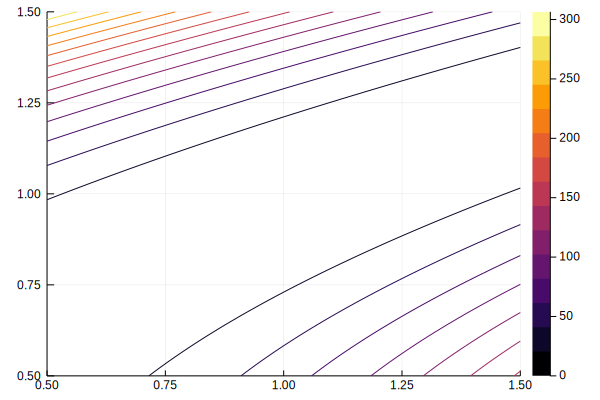

In [43]:
xran = 0.5:0.01:1.5
yran = 0.5:0.01:1.5
Plots.plot(xran, yran, [f([x,y]) for x = xran, y = yran])

In [44]:
# uses finite differences to estimate gradient and Hessian
Optim.minimizer(optimize(f, initial_x, Newton()))

2-element Array{Float64,1}:
 0.9999999926663214
 0.9999999853326412

In [45]:
# uses automatic differentiation
Optim.minimizer(optimize(f, initial_x, Newton(); autodiff=:forward))

2-element Array{Float64,1}:
 0.9999999999999994
 0.9999999999999989

# NLopt.jl

In [48]:
import NLopt

In [51]:
function myfunc(x::Vector, grad::Vector)
    if length(grad) > 0
        grad[1] = 0
        grad[2] = 0.5/sqrt(x[2])
    end
    return sqrt(x[2])
end

function myconstraint(x::Vector, grad::Vector, a, b)
    if length(grad) > 0
        grad[1] = 3a * (a*x[1] + b)^2
        grad[2] = -1
    end
    (a*x[1] + b)^3 - x[2]
end

opt = NLopt.Opt(:LD_MMA, 2)
NLopt.lower_bounds!(opt, [-Inf, 0.])
NLopt.xtol_rel!(opt,1e-4)

NLopt.min_objective!(opt, myfunc)
NLopt.inequality_constraint!(opt, (x,g) -> myconstraint(x,g,2,0), 1e-8)
NLopt.inequality_constraint!(opt, (x,g) -> myconstraint(x,g,-1,1), 1e-8)

(minf,minx,ret) = NLopt.optimize(opt, [1.234, 5.678])
count = opt.numevals # the number of function evaluations
println("got $minf at $minx after $count iterations (returned $ret)")

got 0.5443310477213124 at [0.333333, 0.296296] after 11 iterations (returned XTOL_REACHED)


# Convex.jl

In [53]:
# Make the Convex.jl module available
import Convex, ECOS

# Generate random problem data
m = 4;	n = 5
A = randn(m, n); b = randn(m, 1)

# Create a (column vector) variable of size n x 1.
x = Convex.Variable(n)

# The problem is to minimize ||Ax - b||^2 subject to x >= 0
# This can be done by: minimize(objective, constraints)
problem = Convex.minimize(Convex.sumsquares(A * x - b), [x >= 0])

# Solve the problem by calling solve!
Convex.solve!(problem, ECOS.ECOSSolver())

# Check the status of the problem
problem.status # :Optimal, :Infeasible, :Unbounded etc.

# Get the optimum value
problem.optval

ArgumentError: ArgumentError: Package ECOS not found in current path:
- Run `import Pkg; Pkg.add("ECOS")` to install the ECOS package.


# Automatic differentiation

In [13]:
import ForwardDiff

# JuMP

**El problema de la mochila.**
Tenemos un número de objetos, cada uno con una ganancia y un peso definidos.
Debemos decidir qué objetos meter en la mochila, maximizando la ganacia total, y sabiendo que la mochila puede almacenar un peso máximo.
Es un *problema de programación lineal entera*.

In [79]:
import JuMP, GLPK, Test
const MOI = JuMP.MathOptInterface

profit = [5, 3, 2, 7, 4]
weight = [2, 8, 4, 2, 5]
capacity = 10

model = JuMP.Model(JuMP.with_optimizer(GLPK.Optimizer))

JuMP.@variable(model, x[1:5], Bin)
# Objective: maximize profit
JuMP.@objective(model, Max, profit' * x)
# Constraint: can carry all
JuMP.@constraint(model, weight' * x <= capacity)

model

A JuMP Model
Maximization problem with:
Variables: 5
Objective function type: GenericAffExpr{Float64,VariableRef}
`VariableRef`-in-`MathOptInterface.ZeroOne`: 5 constraints
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 1 constraint
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK
Names registered in the model: x

In [60]:
# Solve problem using MIP solver
JuMP.optimize!(model)

println("Objective is: ", JuMP.objective_value(model))
println("Solution is:")
for i in 1:5
    print("x[$i] = ", JuMP.value(x[i]))
    println(", p[$i]/w[$i] = ", profit[i] / weight[i])
end

Objective is: 16.0
Solution is:
x[1] = 1.0, p[1]/w[1] = 2.5
x[2] = 0.0, p[2]/w[2] = 0.375
x[3] = 0.0, p[3]/w[3] = 0.5
x[4] = 1.0, p[4]/w[4] = 3.5
x[5] = 1.0, p[5]/w[5] = 0.8


In [61]:
JuMP.termination_status(model) == MOI.OPTIMAL

true

In [62]:
JuMP.primal_status(model) == MOI.FEASIBLE_POINT

true

In [63]:
JuMP.objective_value(model) == 16.0

true

## Sudoku

In [76]:
#  Copyright 2017, Iain Dunning, Joey Huchette, Miles Lubin, and contributors
#  This Source Code Form is subject to the terms of the Mozilla Public
#  License, v. 2.0. If a copy of the MPL was not distributed with this
#  file, You can obtain one at http://mozilla.org/MPL/2.0/.
#############################################################################
# JuMP
# An algebraic modeling language for Julia
# See http://github.com/JuliaOpt/JuMP.jl
#############################################################################

using JuMP, GLPK, Test
const MOI = JuMP.MathOptInterface

"""
    example_sudoku(filepath)

A sudoku solver that uses a MIP to find solutions.

We have binary variables x[i, j, k] which, if = 1, say that cell (i, j) contains
the number k. The constraints are:
 1 - Each cell has one value only
 2 - Each row contains each number exactly once
 3 - Each column contains each number exactly once
 4 - Each 3x3 subgrid contains each number exactly once
We will take the initial grid as a CSV file at `filepath`, where 0s are blanks.
"""
function example_sudoku(filepath)
    initial_grid = zeros(Int, 9, 9)
    open(filepath, "r") do fp
        for row in 1:9
            line = readline(fp)
            initial_grid[row, :] .= parse.(Int, split(line, ","))
        end
    end

    model = Model(with_optimizer(GLPK.Optimizer))

    @variable(model, x[1:9, 1:9, 1:9], Bin)

    @constraints(model, begin
        # Constraint 1 - Only one value appears in each cell
        cell[i in 1:9, j in 1:9], sum(x[i, j, :]) == 1
        # Constraint 2 - Each value appears in each row once only
        row[i in 1:9, k in 1:9], sum(x[i, :, k]) == 1
        # Constraint 3 - Each value appears in each column once only
        col[j in 1:9, k in 1:9], sum(x[:, j, k]) == 1
        # Constraint 4 - Each value appears in each 3x3 subgrid once only
        subgrid[i=1:3:7, j=1:3:7, val=1:9], sum(x[i:i + 2, j:j + 2, val]) == 1
    end)

    # Initial solution
    for row in 1:9, col in 1:9
        if initial_grid[row, col] != 0
            @constraint(model, x[row, col, initial_grid[row, col]] == 1)
        end
    end

    # Solve it
    JuMP.optimize!(model)

    term_status = JuMP.termination_status(model)
    primal_status = JuMP.primal_status(model)
    is_optimal = term_status == MOI.OPTIMAL

    # Check solution
    if is_optimal
        mip_solution = JuMP.value.(x)
        sol = zeros(Int, 9, 9)
        for row in 1:9, col in 1:9, val in 1:9
            if mip_solution[row, col, val] >= 0.9
                sol[row, col] = val
            end
        end
        return sol
    else
        error("The solver did not find an optimal solution.")
    end
end

function print_sudoku_solution(solution)
    println("Solution:")
    println("[-----------------------]")
    for row in 1:9
        print("[ ")
        for col in 1:9
            print(solution[row, col], " ")
            if col % 3 == 0 && col < 9
                print("| ")
            end
        end
        println("]")
        if row % 3 == 0
            println("[-----------------------]")
        end
    end
end

solution = example_sudoku("../../jupyter/sudoku.csv")
@test solution == [
    3 1 7 9 5 8 2 6 4;
    4 6 9 3 2 7 8 1 5;
    8 2 5 1 6 4 7 9 3;
    2 7 1 6 4 5 3 8 9;
    9 3 8 7 1 2 5 4 6;
    5 4 6 8 3 9 1 7 2;
    1 8 4 2 9 3 6 5 7;
    6 9 2 5 7 1 4 3 8;
    7 5 3 4 8 6 9 2 1]

Test Passed